Step 1: Setting Up the Environment

Install required packages

In [1]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wavfile
from openai import OpenAI
import io
import os
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display, Markdown
import time
import librosa
import librosa.display
import soundfile as sf
from dotenv import load_dotenv

load_dotenv()

# Set up OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Create directories for storing recordings
os.makedirs('recordings', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("✅ Setup complete!")

✅ Setup complete!


 Setting Up Open AI API key access

In [2]:
import os
from dotenv import load_dotenv

# The "../" tells Python to look one folder up (in the WEEK 1 root)
load_dotenv("../.env")

# Retrieve the key
api_key = os.getenv("OPENAI_API_KEY")

if api_key:
    print("✅ API Key successfully loaded!")
else:
    print("❌ API Key not found. Check your .env file location.")

✅ API Key successfully loaded!


Step 2: Downloading Sample Meeting Audio

Verify the file is accessible

In [3]:
import os

# Define the path to your downloaded file
file_path = 'recordings/arthur.mp3' 

# Check if the file exists
if os.path.exists(file_path):
    # Get file size in Megabytes
    file_size = os.path.getsize(file_path) / (1024 * 1024)
    print(f"✅ File found: {file_path}")
    print(f"📁 File size: {file_size:.2f} MB")
else:
    print(f"❌ File NOT found at {file_path}")
    print(f"📂 Current directory contents: {os.listdir('recordings')}")

✅ File found: recordings/arthur.mp3
📁 File size: 3.05 MB


Check Audio Properties

⏱️ Duration: 228.36 seconds (approx 3.81 minutes)
📢 Sample Rate: 44100 Hz


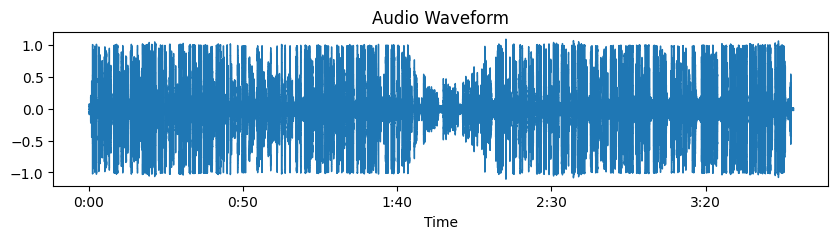

In [4]:
try:
    # Load metadata without loading the whole audio into memory
    y, sr = librosa.load(file_path, sr=None) 
    duration = librosa.get_duration(y=y, sr=sr)
    
    print(f"⏱️ Duration: {duration:.2f} seconds (approx {duration/60:.2f} minutes)")
    print(f"📢 Sample Rate: {sr} Hz")
    
    # Quick visual check to see if the audio actually has sound (not silence)
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Audio Waveform")
    plt.show()

except Exception as e:
    print(f"❌ Error reading audio properties: {e}")

Step 3: Basic Transcription (Without Chunking)

In [5]:
import io

# 1. Define the path (assuming you moved it to recordings/ or updated the path)
file_path = 'recordings/arthur.mp3' 

# 2. Extract just a "short part" (first 30 seconds) using librosa
# This prevents sending a massive file if the meeting is long
short_audio, sr = librosa.load(file_path, duration=30)

# 3. Save this snippet to a buffer (in-memory file) so we don't need to save a new file to disk
buffer = io.BytesIO()
sf.write(buffer, short_audio, sr, format='wav')
buffer.seek(0)
buffer.name = "segment.wav" # Whisper needs a filename/extension to identify format

print("⏳ Sending short segment to OpenAI Whisper...")

try:
    # 4. Request transcription
    transcript = client.audio.transcriptions.create(
        model="whisper-1", 
        file=buffer
    )

    # 5. Display the result
    print("✅ Transcription Complete:\n")
    display(Markdown(f"> {transcript.text}"))

except Exception as e:
    print(f"❌ Transcription failed: {e}")

⏳ Sending short segment to OpenAI Whisper...
✅ Transcription Complete:



> The story of Arthur the Rat. Once upon a time, there was a young rat who couldn't make up his mind. Whenever the other rats asked him if he would like to come out hunting with them, he would answer in a hoarse voice, I don't know. And when they said, would you rather stay inside, he would say yes or no either. He'd always shake making a choice. One fine day...

Understand the API response format

Detailed Format (verbose_json)
This is the most useful format for data analysis. It provides timestamps, language detection, and confidence scores.

In [8]:
# The structure is much richer:
{
  "task": "transcribe",
  "language": "english",
  "duration": 30.0,
  "text": "Hello world...",
  "segments": [
    {
      "id": 0,
      "start": 0.0,
      "end": 2.5,
      "text": "Hello world",
      "avg_logprob": -0.15,  # Higher is better
      "compression_ratio": 1.2,
      "no_speech_prob": 0.01
    }
  ]
}

{'task': 'transcribe',
 'language': 'english',
 'duration': 30.0,
 'text': 'Hello world...',
 'segments': [{'id': 0,
   'start': 0.0,
   'end': 2.5,
   'text': 'Hello world',
   'avg_logprob': -0.15,
   'compression_ratio': 1.2,
   'no_speech_prob': 0.01}]}

Extract basic transcription text

In [9]:
# 1. Prepare your file (using the first 30 seconds)
audio_segment, sr = librosa.load('recordings/Arthur.mp3', duration=30)
buffer = io.BytesIO()
sf.write(buffer, audio_segment, sr, format='wav')
buffer.seek(0)
buffer.name = "arthur.wav"

# 2. Extract plain text only
# By setting response_format="text", the result is a string, not a JSON object
simple_transcript = client.audio.transcriptions.create(
    model="whisper-1", 
    file=buffer,
    response_format="text"
)

print("📝 Clean Transcription Text:")
print(simple_transcript)

📝 Clean Transcription Text:
The story of Arthur the Rat. Once upon a time, there was a young rat who couldn't make up his mind. Whenever the other rats asked him if he would like to come out hunting with them, he would answer in a hoarse voice, I don't know. And when they said, would you rather stay inside, he would say yes or no either. He'd always shake making a choice. One fine day...



Saving the Result

In [10]:
with open("results/arthur_transcript.txt", "w") as f:
    f.write(simple_transcript)
print("\n✅ Saved to results/arthur_transcript.txt")


✅ Saved to results/arthur_transcript.txt


Step 4: Transcription with Prompts (Guided Approach)

Create prompts with context (technical terms, names, etc.)

In [11]:
# 1. Define the context (Technical terms, names, unusual spellings)
# This helps Whisper correctly identify "Arthur", "hoarse", and the flow of the story.
context_prompt = "Arthur the Rat, a young rat who couldn't make up his mind. Discussing hunting, staying inside, and making choices."

try:
    # 2. Transcribe with the context prompt
    response = client.audio.transcriptions.create(
        model="whisper-1", 
        file=buffer, # Your audio buffer from previous steps
        response_format="verbose_json",
        prompt=context_prompt  # <--- This is where the magic happens
    )

    print("📜 TRANSCRIPTION WITH CONTEXT:")
    print(response.text)

except Exception as e:
    print(f"❌ Error: {e}")

📜 TRANSCRIPTION WITH CONTEXT:
The Story of Arthur the Rat Once upon a time there was a young rat who couldn't make up his mind. Whenever the other rats asked him if he would like to come out hunting with them, he would answer in a hoarse voice, I don't know. And when they said, would you rather stay inside, he would say yes or no either. He'd always shake making a choice. One fine day...


Transcribe with prompts

In [13]:
import io
import soundfile as sf  # soundfile
import librosa

# 1. Load the audio from your recordings folder
file_path = 'recordings/Arthur.mp3'
audio, sr = librosa.load(file_path, duration=30)

# 2. Convert to a format Whisper understands (in-memory)
buffer = io.BytesIO()
sf.write(buffer, audio, sr, format='wav')
buffer.seek(0)
buffer.name = "arthur_segment.wav"

# 3. Define your Context Prompt
# We include specific names and the slightly unusual "hoarse voice" phrase
meeting_context = "This is the story of Arthur the Rat. He speaks in a hoarse voice and struggles with making a choice."

try:
    print("⏳ Transcribing with custom context...")
    
    # 4. Request transcription with the prompt
    response = client.audio.transcriptions.create(
        model="whisper-1",
        file=buffer,
        prompt=meeting_context,  # Guiding the AI's vocabulary
        response_format="text"   # Keeping it simple for extraction
    )

    print("\n✅ PROMPTED TRANSCRIPTION:")
    print("-" * 30)
    print(response)
    print("-" * 30)

except Exception as e:
    print(f"❌ API Error: {e}")

⏳ Transcribing with custom context...

✅ PROMPTED TRANSCRIPTION:
------------------------------
The story of Arthur the Rat. Once upon a time there was a young rat who couldn't make up his mind. Whenever the other rats asked him if he would like to come out hunting with them, he would answer in a hoarse voice, I don't know. And when they said, would you rather stay inside, he would say yes or no either. He'd always shake making a choice. One fine day...

------------------------------


Compare results. This one the output I didn't like

In [14]:
# Create a list to store our comparison data
comparison_data = []

# Method A: Basic Text (Simple)
res_text = client.audio.transcriptions.create(
    model="whisper-1",
    file=buffer, # use the same buffer from your previous cell
    prompt=meeting_context,
    response_format="text"
)

# Method B: Verbose JSON (Detailed)
res_verbose = client.audio.transcriptions.create(
    model="whisper-1",
    file=buffer,
    prompt=meeting_context,
    response_format="verbose_json"
)

print("📊 COMPARISON SUMMARY")
print(f"{'Format':<15} | {'Content Summary'}")
print("-" * 50)
print(f"{'Plain Text':<15} | {res_text[:60]}...")
print(f"{'Verbose JSON':<15} | Detected Language: {res_verbose.language}, Segments: {len(res_verbose.segments)}")

📊 COMPARISON SUMMARY
Format          | Content Summary
--------------------------------------------------
Plain Text      | The story of Arthur the Rat. Once upon a time there was a yo...
Verbose JSON    | Detected Language: english, Segments: 6


Proper comparison

In [18]:
# 1. Transcribe with NO PROMPT (The "Cold" Start)
res_no_prompt = client.audio.transcriptions.create(
    model="whisper-1",
    file=buffer,
    response_format="text" # No prompt used here
)

# 2. Transcribe WITH PROMPT (The "Guided" Start)
res_with_prompt = client.audio.transcriptions.create(
    model="whisper-1",
    file=buffer,
    prompt="Arthur the Rat, hoarse voice, hunting, making a choice.",
    response_format="text"
)

# 3. Compare the strings directly
print("🧪 THE QUALITY TEST")
print("-" * 50)
print(f"❌ WITHOUT PROMPT:\n{res_no_prompt[:150]}...")
print("\n" + "-" * 50)
print(f"✅ WITH PROMPT:\n{res_with_prompt[:150]}...")

🧪 THE QUALITY TEST
--------------------------------------------------
❌ WITHOUT PROMPT:
The story of Arthur the Rat. Once upon a time, there was a young rat who couldn't make up his mind. Whenever the other rats asked him if he would like...

--------------------------------------------------
✅ WITH PROMPT:
The story of Arthur the Rat. Once upon a time there was a young rat who couldn't make up his mind. Whenever the other rats asked him if he would like ...


Visualizing the segments

In [ ]:
for segment in res_verbose.segments:
    start = segment.start
    end = segment.end
    text = segment.text
    print(f"[{start:5.2f}s -> {end:5.2f}s]: {text}")

[ 1.00s ->  8.00s]:  The story of Arthur the Rat. Once upon a time there was a young rat who couldn't make up his mind.
[ 8.00s -> 13.00s]:  Whenever the other rats asked him if he would like to come out hunting with them,
[13.00s -> 17.00s]:  he would answer in a hoarse voice, I don't know.
[17.00s -> 24.00s]:  And when they said, would you rather stay inside, he would say yes or no either.
[24.00s -> 28.00s]:  He'd always shake making a choice.
[28.00s -> 30.00s]:  One fine day...


In [ ]:
Save results in .txt

In [19]:
# Define the filename
text_filename = "results/arthur_transcription.txt"

# Save the string result
with open(text_filename, "w", encoding="utf-8") as f:
    f.write(res_with_prompt)

print(f"💾 Saved text to: {text_filename}")

💾 Saved text to: results/arthur_transcription.txt


Save the Detailed Data (.json)

In [20]:
import json

# Convert the Pydantic object to a dictionary
data_to_save = res_verbose.model_dump()

json_filename = "results/arthur_metadata.json"

with open(json_filename, "w", encoding="utf-8") as f:
    json.dump(data_to_save, f, indent=4)

print(f"💾 Saved metadata to: {json_filename}")

💾 Saved metadata to: results/arthur_metadata.json


Step 5: Transcription Without Prompts (Unguided Approach)

In [ ]:
Transcribe without any prompt I mean I did this before. With this I'm saving files in an ordered way

In [22]:
try:
    print("⏳ Running raw transcription (No Prompt)...")
    
    # 1. Generate the raw response
    raw_response = client.audio.transcriptions.create(
        model="whisper-1",
        file=buffer, # Ensure 'buffer' from the previous steps is still in memory
        response_format="text"
    )

    # 2. Save the version with the prompt (assuming res_with_prompt exists)
    with open("results/transcript_WITH_prompt.txt", "w", encoding="utf-8") as f:
        f.write(res_with_prompt)

    # 3. Save the version WITHOUT the prompt
    with open("results/transcript_NO_prompt.txt", "w", encoding="utf-8") as f:
        f.write(raw_response)

    print("✅ Success! Both files are now in the /results folder.")

except NameError as e:
    print(f"❌ Error: A variable is missing. Did you skip a cell? {e}")
except Exception as e:
    print(f"❌ API Error: {e}")

⏳ Running raw transcription (No Prompt)...
✅ Success! Both files are now in the /results folder.


Comparison

Visual one

In [24]:
# 1. Ensure both variables exist
try:
    print("📊 TRANSCRIPTION COMPARISON")
    print("=" * 60)
    
    print("\n❌ WITHOUT PROMPT (Raw Interpretation):")
    print(raw_response)
    
    print("\n" + "=" * 60)
    
    print("\n✅ WITH PROMPT (Guided by Context):")
    print(res_with_prompt)
    
except NameError:
    print("❌ Error: One of the transcription variables is missing. Please re-run the transcription cells.")

📊 TRANSCRIPTION COMPARISON

❌ WITHOUT PROMPT (Raw Interpretation):
The story of Arthur the Rat. Once upon a time, there was a young rat who couldn't make up his mind. Whenever the other rats asked him if he would like to come out hunting with them, he would answer in a hoarse voice, I don't know. And when they said, would you rather stay inside, he would say yes or no either. He'd always shake making a choice. One fine day...



✅ WITH PROMPT (Guided by Context):
The story of Arthur the Rat. Once upon a time there was a young rat who couldn't make up his mind. Whenever the other rats asked him if he would like to come out hunting with them, he would answer in a hoarse voice, I don't know. And when they said, would you rather stay inside, he would say yes or no either. He'd always shake making a choice. One fine day...



Quantitative difference

In [25]:
diff_length = len(res_with_prompt) - len(raw_response)

print(f"📏 Length Difference: {abs(diff_length)} characters")
if diff_length > 0:
    print("💡 The prompted version is more descriptive or used more punctuation.")
else:
    print("💡 The raw version was longer/more wordy.")

📏 Length Difference: 1 characters
💡 The raw version was longer/more wordy.


Analize differences

In [26]:
import difflib

# Split the texts into lines for the Differ
raw_lines = raw_response.splitlines()
prompted_lines = res_with_prompt.splitlines()

d = difflib.Differ()
diff = d.compare(raw_lines, prompted_lines)

print("📝 WORD-BY-WORD DELTA:")
print("-" * 40)
print('\n'.join(diff))

📝 WORD-BY-WORD DELTA:
----------------------------------------
- The story of Arthur the Rat. Once upon a time, there was a young rat who couldn't make up his mind. Whenever the other rats asked him if he would like to come out hunting with them, he would answer in a hoarse voice, I don't know. And when they said, would you rather stay inside, he would say yes or no either. He'd always shake making a choice. One fine day...
+ The story of Arthur the Rat. Once upon a time there was a young rat who couldn't make up his mind. Whenever the other rats asked him if he would like to come out hunting with them, he would answer in a hoarse voice, I don't know. And when they said, would you rather stay inside, he would say yes or no either. He'd always shake making a choice. One fine day...


Lines starting with - are from the Raw version.

Lines starting with + are from the Prompted version.

Step 6: Implementing Audio Chunking

Split audio into manageable chunks (e.g., 10-minute segments)

In [30]:
import os
import soundfile as sf
import librosa
import math

# 1. Configuration
input_file = 'recordings/Arthur.mp3'
chunk_duration_min = 1
chunk_duration_sec = chunk_duration_min * 60

# 2. Load the full file
# Note: For very large files, we'd use 'sr=None' to keep original quality
y, sr = librosa.load(input_file, sr=None)
total_duration = librosa.get_duration(y=y, sr=sr)

# 3. Calculate how many chunks we need
num_chunks = math.ceil(total_duration / chunk_duration_sec)

print(f"⏱️ Total Duration: {total_duration:.2f}s")
print(f"📦 Splitting into {num_chunks} chunk(s)...")

# 4. Loop and Save
for i in range(num_chunks):
    start_sec = i * chunk_duration_sec
    end_sec = min((i + 1) * chunk_duration_sec, total_duration)
    
    # Slice the array: y[start_sample : end_sample]
    start_sample = int(start_sec * sr)
    end_sample = int(end_sec * sr)
    chunk = y[start_sample:end_sample]
    
    # Save to the recordings folder
    chunk_filename = f"recordings/Arthur_part_{i+1}.wav"
    sf.write(chunk_filename, chunk, sr)
    print(f"💾 Saved: {chunk_filename} ({start_sec}s to {end_sec}s)")

print("\n✅ All chunks are ready in the /recordings folder.")

⏱️ Total Duration: 228.36s
📦 Splitting into 4 chunk(s)...
💾 Saved: recordings/Arthur_part_1.wav (0s to 60s)
💾 Saved: recordings/Arthur_part_2.wav (60s to 120s)
💾 Saved: recordings/Arthur_part_3.wav (120s to 180s)
💾 Saved: recordings/Arthur_part_4.wav (180s to 228.36244897959185s)

✅ All chunks are ready in the /recordings folder.


Process each chunk separately

In [31]:
import os

# 1. Identify all chunks created in the previous step
chunks = sorted([f for f in os.listdir('recordings') if 'Arthur_part_' in f])
full_transcript = []

print(f"🔄 Found {len(chunks)} chunks to process...")

# 2. Loop through each chunk
for chunk_name in chunks:
    file_path = f"recordings/{chunk_name}"
    
    with open(file_path, "rb") as audio_file:
        print(f"⏳ Transcribing {chunk_name}...")
        
        # We use the 'prompt' here too to maintain consistency across chunks
        response = client.audio.transcriptions.create(
            model="whisper-1",
            file=audio_file,
            prompt="Arthur the Rat story, continued.",
            response_format="text"
        )
        
        # Store the result
        full_transcript.append(response)

# 3. Join everything into one string
final_text = "\n".join(full_transcript)

# 4. Save the combined result
with open("results/Arthur_FULL_transcript.txt", "w", encoding="utf-8") as f:
    f.write(final_text)

print("\n✅ Processing complete! Final transcript saved to results/Arthur_FULL_transcript.txt")

🔄 Found 4 chunks to process...
⏳ Transcribing Arthur_part_1.wav...
⏳ Transcribing Arthur_part_2.wav...
⏳ Transcribing Arthur_part_3.wav...
⏳ Transcribing Arthur_part_4.wav...

✅ Processing complete! Final transcript saved to results/Arthur_FULL_transcript.txt


Combine results with proper timestamps

In [32]:
import os

chunks = sorted([f for f in os.listdir('recordings') if 'Arthur_part_' in f])
combined_segments = []
current_offset = 0.0  # This tracks our position in the overall timeline

print(f"🚀 Processing {len(chunks)} chunks with timestamp synchronization...")

for chunk_name in chunks:
    file_path = f"recordings/{chunk_name}"
    
    with open(file_path, "rb") as audio_file:
        # 1. Get verbose_json to access segment-level timestamps
        response = client.audio.transcriptions.create(
            model="whisper-1",
            file=audio_file,
            response_format="verbose_json",
            prompt="Arthur the Rat."
        )
        
        # 2. Adjust each segment's time by the current offset
        for segment in response.segments:
            combined_segments.append({
                "start": segment.start + current_offset,
                "end": segment.end + current_offset,
                "text": segment.text.strip()
            })
        
        # 3. Update the offset by the total duration of this chunk
        current_offset += response.duration

print("✅ All chunks synced.")

# 4. Format and save the final result
with open("results/Arthur_TIMED_transcript.txt", "w", encoding="utf-8") as f:
    for s in combined_segments:
        # Formatting seconds into MM:SS
        start_min = int(s['start'] // 60)
        start_sec = int(s['start'] % 60)
        timestamp = f"[{start_min:02d}:{start_sec:02d}]"
        
        line = f"{timestamp} {s['text']}\n"
        f.write(line)
        print(line, end="")

🚀 Processing 4 chunks with timestamp synchronization...
✅ All chunks synced.
[00:00] The story of Arthur the Rat. Once upon a time there was a young rat who couldn't
[00:06] make up his mind. Whenever the other rats asked him if he would like to come out
[00:11] hunting with them, he would answer in a hoarse voice, I don't know. And when they
[00:17] said, would you rather stay inside, he would say yes or no either. He'd always
[00:25] shake making a choice. One fine day his Aunt Josephine said to him, now look here,
[00:32] no one will ever care for you if you carry on like this. You have no more mind
[00:37] of your own than a greasy old blade of grass. The young rat coughed and looked quiet as
[00:42] usual but said nothing. Don't you think so, said his aunt, stamping her foot, for she
[00:49] couldn't bear to see the young rat so cold-blooded. I don't know was all he
[00:56] ever answered and then he walked off to think.
[01:00] for an hour or more. Rather he would stay in his hole

Step 7: Transcribing Chunks with Timestamps

Transcribe each chunk

Step 1: The Transcription Loop

In [33]:
import os

# 1. Get all chunks in alphabetical/numerical order
chunks = sorted([f for f in os.listdir('recordings') if 'Arthur_part_' in f])
all_responses = []

print(f"🔄 Found {len(chunks)} chunks. Starting transcription...")

# 2. Transcribe each file
for i, chunk_name in enumerate(chunks):
    file_path = f"recordings/{chunk_name}"
    
    with open(file_path, "rb") as audio_file:
        print(f"📑 Processing Part {i+1}: {chunk_name}...")
        
        # Using verbose_json to get the 'duration' and 'segments'
        response = client.audio.transcriptions.create(
            model="whisper-1",
            file=audio_file,
            response_format="verbose_json",
            prompt="Arthur the Rat story, continued."
        )
        all_responses.append(response)

print("✅ All chunks transcribed successfully.")

🔄 Found 4 chunks. Starting transcription...
📑 Processing Part 1: Arthur_part_1.wav...
📑 Processing Part 2: Arthur_part_2.wav...
📑 Processing Part 3: Arthur_part_3.wav...
📑 Processing Part 4: Arthur_part_4.wav...
✅ All chunks transcribed successfully.


Merging global time

In [34]:
combined_data = []
global_offset = 0.0

for resp in all_responses:
    # Add each segment to our master list with adjusted times
    for segment in resp.segments:
        combined_data.append({
            "start": segment.start + global_offset,
            "end": segment.end + global_offset,
            "text": segment.text.strip()
        })
    
    # Increase the offset by the actual duration of the chunk just processed
    global_offset += resp.duration

print(f"📏 Total transcribed duration: {global_offset:.2f} seconds")

📏 Total transcribed duration: 228.36 seconds


Adjust timestamps to account for chunk offset

In [36]:
# Print the first and last segment to verify the span
if synchronized_segments:
    first = synchronized_segments[0]
    last = synchronized_segments[-1]
    print(f"First Segment: [{first['start']:.2f}s] {first['text'][:30]}...")
    print(f"Last Segment:  [{last['start']:.2f}s] {last['text'][:30]}...")

First Segment: [0.00s] The story of Arthur the Rat. O...
Last Segment:  [222.12s] Thus, the shirker got his due,...


Combine all transcriptions

In [37]:
# Final consolidation into a readable document
output_path = "results/Arthur_FULL_30s_Intervals.txt"
next_marker = 30.0

with open(output_path, "w", encoding="utf-8") as f:
    f.write("--- 00:00 ---\n") # Start header
    
    for s in synchronized_segments:
        # If the segment starts after our next 30s milestone
        if s['start'] >= next_marker:
            m = int(next_marker // 60)
            sec = int(next_marker % 60)
            f.write(f"\n\n--- {m:02d}:{sec:02d} ---\n")
            
            # Catch up the marker if there was a long gap
            while s['start'] >= next_marker:
                next_marker += 30.0
        
        f.write(f"{s['text']} ")

print(f"✅ Created readable transcript: {output_path}")

✅ Created readable transcript: results/Arthur_FULL_30s_Intervals.txt


Export with timestamps

In [38]:
# Save as a standard timestamped text file
output_path_txt = "results/Arthur_Timed_Transcript.txt"

with open(output_path_txt, "w", encoding="utf-8") as f:
    for s in synchronized_segments:
        # Calculate minutes and seconds
        m = int(s['start'] // 60)
        sec = int(s['start'] % 60)
        
        # Format: [01:30] This is the text.
        timestamp = f"[{m:02d}:{sec:02d}]"
        f.write(f"{timestamp} {s['text']}\n")

print(f"💾 Exported readable transcript to: {output_path_txt}")

💾 Exported readable transcript to: results/Arthur_Timed_Transcript.txt


Step 8: Exporting with Timestamps

Create human-readable format with timestamps

In [39]:
# 1. Define the output file path
human_readable_path = "results/Arthur_Human_Readable.txt"

print(f"✍️ Writing human-readable transcript to {human_readable_path}...")

with open(human_readable_path, "w", encoding="utf-8") as f:
    f.write("--- ARTHUR THE RAT: TIMED TRANSCRIPT ---\n\n")
    
    for s in synchronized_segments:
        # 2. Calculate minutes and seconds
        total_seconds = s['start']
        minutes = int(total_seconds // 60)
        seconds = int(total_seconds % 60)
        
        # 3. Format timestamp as [MM:SS] (padding with zeros)
        timestamp = f"[{minutes:02d}:{seconds:02d}]"
        
        # 4. Write the line: [01:30] This is the spoken text.
        f.write(f"{timestamp} {s['text']}\n")

print("✅ File successfully saved. You can now open it from the 'results' folder.")

✍️ Writing human-readable transcript to results/Arthur_Human_Readable.txt...
✅ File successfully saved. You can now open it from the 'results' folder.


Fixed Padding: Using :02d ensures that [0:5] becomes [00:05]. This keeps all your text vertically aligned, which is much easier on the eyes.

Segment Logic: Since Whisper breaks segments at natural pauses, each line usually represents a complete thought or sentence.

Global Context: Because we are using the synchronized_segments you created earlier, the time [03:45] correctly refers to the total time from the start of the very first chunk.

Verification of the readability

In [40]:
with open(human_readable_path, "r") as f:
    lines = f.readlines()
    for line in lines[2:7]: # Skip the header
        print(line.strip())

[00:00] The story of Arthur the Rat. Once upon a time there was a young rat who couldn't
[00:06] make up his mind. Whenever the other rats asked him if he would like to come out
[00:11] hunting with them, he would answer in a hoarse voice, I don't know. And when they
[00:17] said, would you rather stay inside, he would say yes or no either. He'd always
[00:25] shake making a choice. One fine day his Aunt Josephine said to him, now look here,


Export to text file

In [41]:
import os

# 1. Define the output path
final_text_path = "results/Arthur_Final_Transcript.txt"

# 2. Calculate final stats for the header
total_duration_sec = synchronized_segments[-1]['end'] if synchronized_segments else 0
m, s = divmod(int(total_duration_sec), 60)

print(f"📄 Exporting final transcript ({m:02d}:{s:02d}) to {final_text_path}...")

with open(final_text_path, "w", encoding="utf-8") as f:
    # Optional: Add a professional header
    f.write("==========================================\n")
    f.write("TRANSCRIPTION REPORT: ARTHUR THE RAT\n")
    f.write(f"Total Duration: {m:02d}:{s:02d}\n")
    f.write("==========================================\n\n")
    
    for segment in synchronized_segments:
        # Format the timestamp
        start_m, start_s = divmod(int(segment['start']), 60)
        timestamp = f"[{start_m:02d}:{start_s:02d}]"
        
        # Write the line
        f.write(f"{timestamp} {segment['text']}\n")

print("✅ Export complete! You can find your file in the 'results' directory.")

📄 Exporting final transcript (03:45) to results/Arthur_Final_Transcript.txt...
✅ Export complete! You can find your file in the 'results' directory.


Export to SRT (subtitle) format

In [42]:
def format_to_srt_time(seconds):
    """Converts raw seconds to SRT format: HH:MM:SS,mmm"""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    milliseconds = int((seconds % 1) * 1000)
    return f"{hours:02d}:{minutes:02d}:{secs:02d},{milliseconds:03d}"

# 1. Define output path
srt_path = "results/Arthur_Subtitles.srt"

print(f"🎬 Generating SRT subtitles at {srt_path}...")

with open(srt_path, "w", encoding="utf-8") as f:
    for i, s in enumerate(synchronized_segments, 1):
        # 2. Convert start and end times
        start_srt = format_to_srt_time(s['start'])
        end_srt = format_to_srt_time(s['end'])
        
        # 3. Write in SRT standard format
        f.write(f"{i}\n")
        f.write(f"{start_srt} --> {end_srt}\n")
        f.write(f"{s['text'].strip()}\n\n")

print("✅ SRT file exported! You can now load this into VLC or YouTube.")

🎬 Generating SRT subtitles at results/Arthur_Subtitles.srt...
✅ SRT file exported! You can now load this into VLC or YouTube.


Export to JSON

In [43]:
import json

# 1. Define the output path
json_path = "results/Arthur_Data.json"

# 2. Prepare the metadata wrapper (optional but recommended)
# This keeps your data organized by including stats like total duration
master_data = {
    "metadata": {
        "filename": "Arthur.mp3",
        "total_segments": len(synchronized_segments),
        "total_duration_sec": synchronized_segments[-1]['end'] if synchronized_segments else 0
    },
    "segments": synchronized_segments
}

# 3. Write to file with 'indent' to make it readable
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(master_data, f, indent=4, ensure_ascii=False)

print(f"📁 JSON Master Data exported to: {json_path}")

📁 JSON Master Data exported to: results/Arthur_Data.json


How to read it back later

In [44]:
with open("results/Arthur_Data.json", "r") as f:
    data = json.load(f)
    
# Now you can access it easily:
print(data['segments'][0]['text']) # Prints the first sentence

The story of Arthur the Rat. Once upon a time there was a young rat who couldn't
